In [67]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import re
import nltk

from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

from collections import Counter

import sentimentLib as stl
import warnings
warnings.filterwarnings("ignore")

# PART 1: Exploratory Data Analysis
### - In this part, we will explore what the dataset looks like as well as its components.


## Prepare Dataset

In [68]:
train = pd.read_csv('COVID19_train.csv',encoding='latin-1')
test = pd.read_csv('COVID19_test.csv',encoding='latin-1')
print(train.shape)
print(test.shape)

(41157, 6)
(3798, 6)


In [69]:
df = pd.concat([train,test],ignore_index=True)
print(df.shape)
df.head(10)

(44955, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


## Data Summary

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


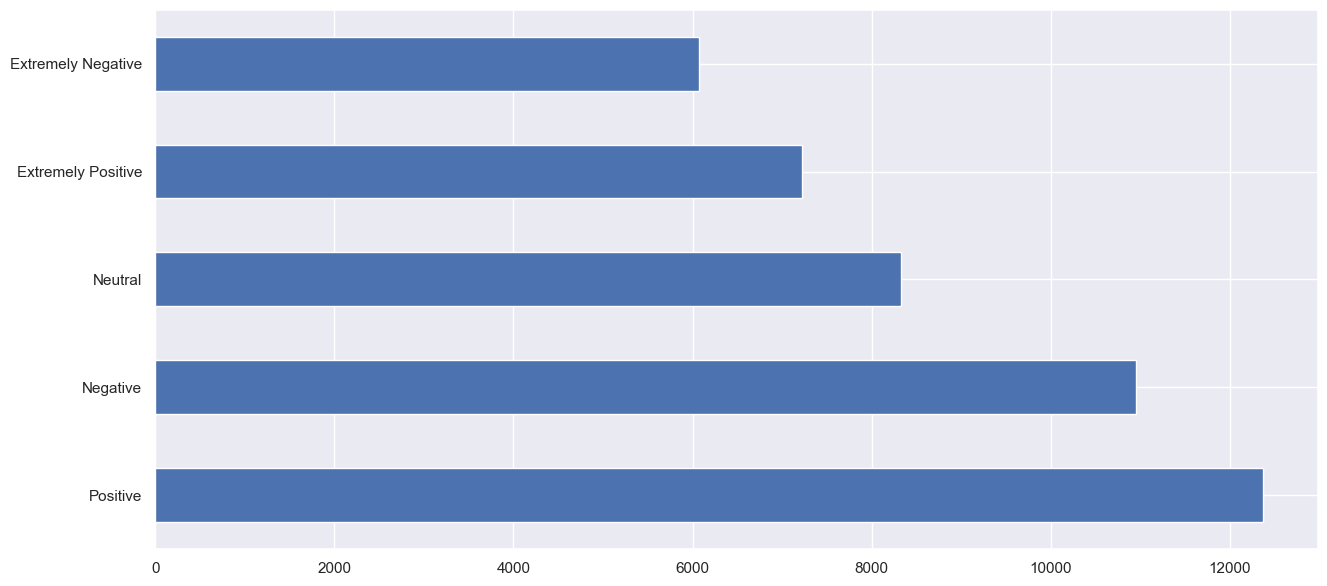

In [70]:
#sentiment plots
print(df.Sentiment.value_counts())
sentiments = df.Sentiment.value_counts()
sentiments.plot(kind='barh');

In [71]:
#Dates plots
df['TweetAt']= pd.to_datetime(df['TweetAt'])
dates = df.groupby('TweetAt').count()['OriginalTweet'].reset_index().sort_values('TweetAt',ascending=True)
dates.head()

,TweetAt,OriginalTweet
0,2020-01-04,630
1,2020-02-03,4
2,2020-02-04,954
3,2020-03-03,4
4,2020-03-04,810


Text(0.5, 1.0, 'Tweets over time')

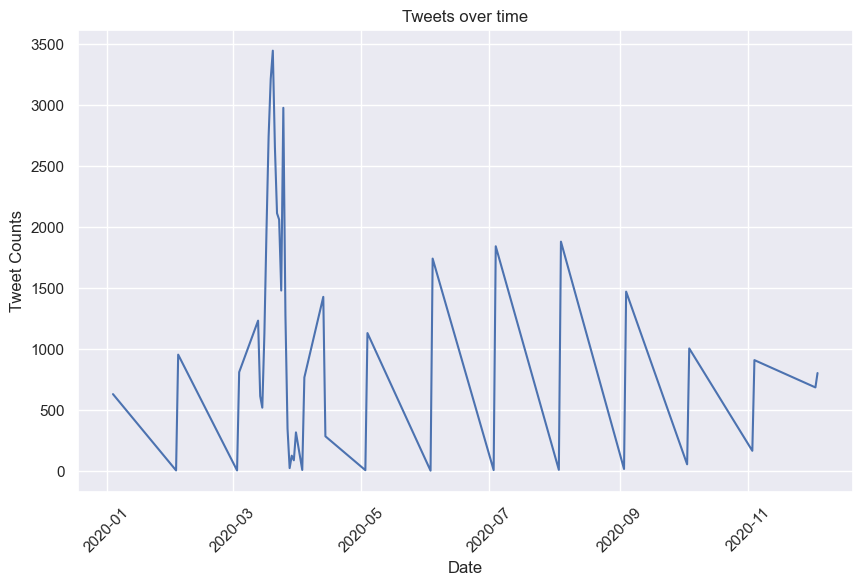

In [73]:
plt.figure(figsize=(10,6))
plt.plot(dates.TweetAt,dates.OriginalTweet)
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Tweet Counts")
plt.title("Tweets over time")

# PART 2: Data Preprocessing
### - In this part, we will preprocess the data

### Check if **NULL** values are in the interested columns(Text, Sentiment)
- Since we don't have null value, it's considered to be safe to proceed.
- If there was a null values, we can "drop" the column or use "Imputation".

In [74]:
print(df.OriginalTweet.isnull().values.any())
print(df.Sentiment.isnull().values.any())

False
False


## 1) Drop unnecessary columns

In [75]:
tweet = df.copy()
tweet.drop(['UserName','ScreenName','Location'],axis=1,inplace=True)
tweet.rename(columns={'OriginalTweet':'Text'},inplace=True)
tweet.head()

,TweetAt,Text,Sentiment
0,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,2020-03-16,My food stock is not the only one which is emp...,Positive
4,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## 2) Categorizing a Sentiment (labels)

-In order to increase the accuracy of prediction, we will convert 5 classes to 3 classes (Positive, Negative, Neutral).

In [76]:
tweet['Sentiment'] = tweet['Sentiment'].apply(lambda x: stl.sentimentClass(x))
tweet['Sentiment'].value_counts()

positive    19592
negative    17031
neutral      8332
Name: Sentiment, dtype: int64

## 3) Remove Punctuations (using regular expression)

In [77]:
for i in range(tweet.shape[0]):
    tweet['Text'][i] = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(#[A-Za-z0-9]+)", " ", tweet['Text'][i]).split()).lower()
tweet.head(10)

,TweetAt,Text,Sentiment
0,2020-03-16,gahan and and,neutral
1,2020-03-16,advice talk to your neighbours family to excha...,positive
2,2020-03-16,coronavirus australia woolworths to give elder...,positive
3,2020-03-16,my food stock is not the only one which is emp...,positive
4,2020-03-16,me ready to go at supermarket during the covid...,negative
5,2020-03-16,as news of the region s first confirmed covid ...,positive
6,2020-03-16,cashier at grocery store was sharing his insig...,positive
7,2020-03-16,was at the supermarket today didn t buy toilet...,neutral
8,2020-03-16,due to covid 19 our retail store and classroom...,positive
9,2020-03-16,for corona prevention we should stop to buy th...,negative


## 4) Remove stopwords and a letter

In [78]:
#Remove stopwords
tweet['Text'] = tweet['Text'].apply(lambda x: stl.remove_stopwords(x))
#Remove a letter
tweet['Text'] = tweet['Text'].apply(lambda x: stl.remove_Aletter(x))

In [79]:
tweet.head()

,TweetAt,Text,Sentiment
0,2020-03-16,gahan,neutral
1,2020-03-16,advice talk neighbours family exchange phone n...,positive
2,2020-03-16,coronavirus australia woolworths give elderly ...,positive
3,2020-03-16,food stock one empty please don panic will eno...,positive
4,2020-03-16,ready go supermarket covid19 outbreak paranoid...,negative


## 5) Visualize distribution of data

positive    19592
negative    17031
neutral      8332
Name: Sentiment, dtype: int64


<Axes: xlabel='Sentiment', ylabel='count'>

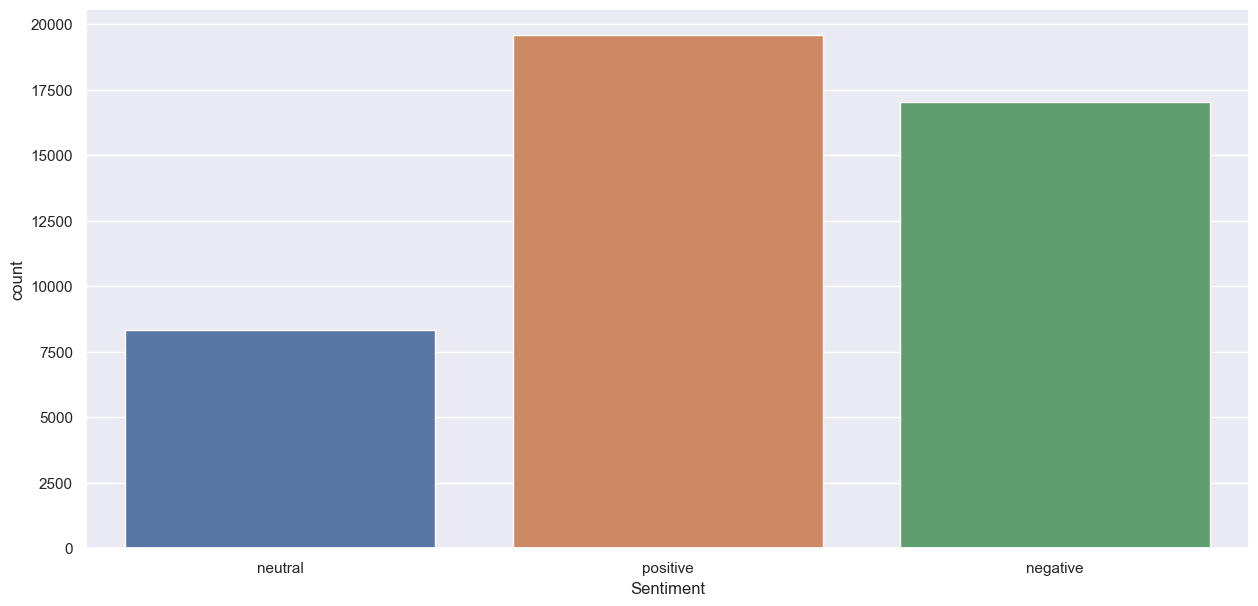

In [81]:
print(tweet.Sentiment.value_counts())
sns.set_theme(style="darkgrid")
sns.countplot(data = tweet, x="Sentiment")

## Visualizing Most Common 100 words

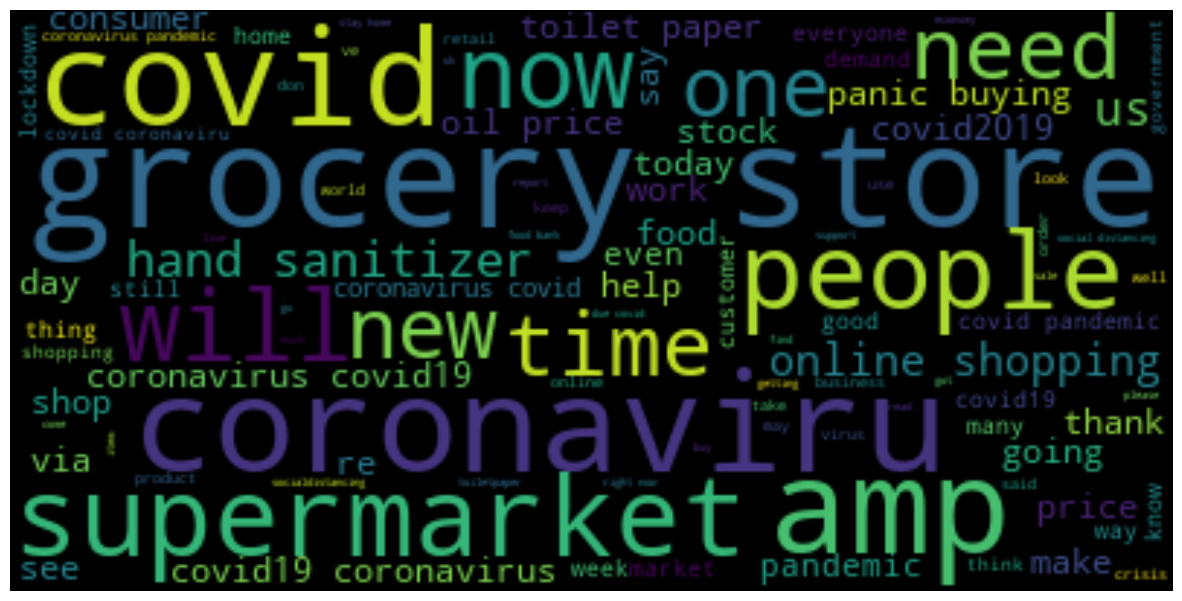

In [82]:
wholeText = ' '.join(tweet.Text)
stl.wordcloud_disp(wholeText,100)

In [83]:
text = tweet.Text.apply(lambda x: x.split(' '))
words =[]
for i in range(len(text)):
    words += text[i]
wordsCount = Counter(words).most_common(20)

Text(0.5, 1.0, '20 Most common words')

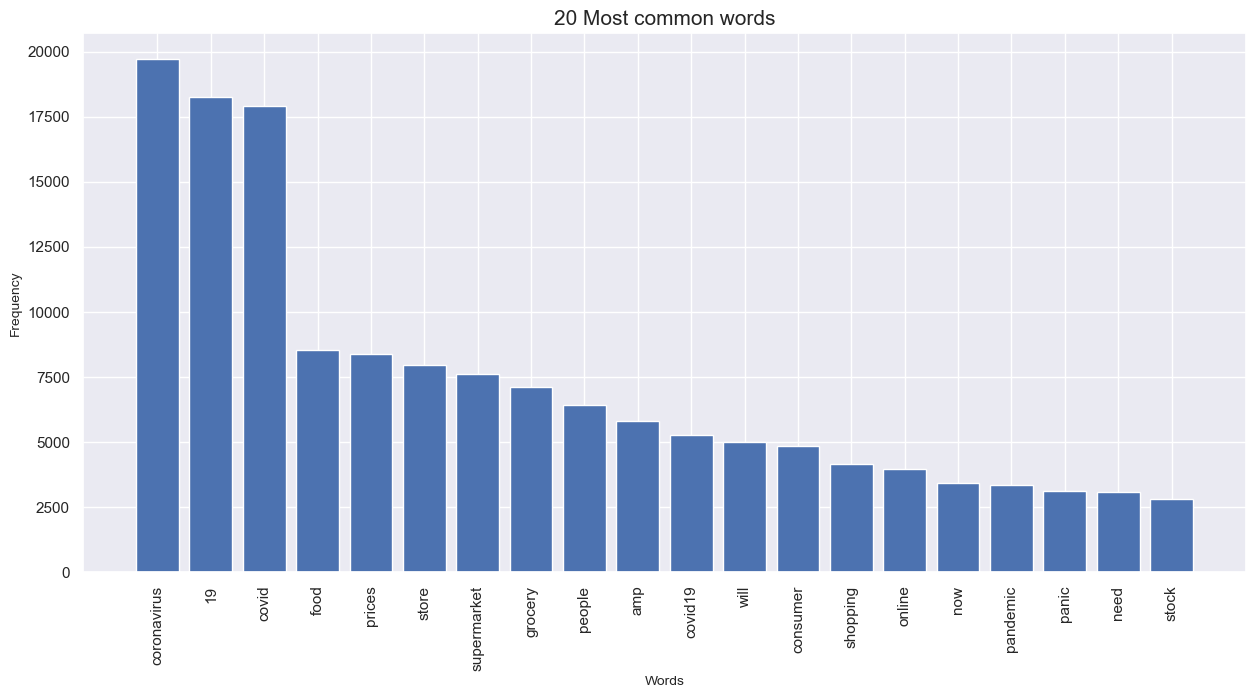

In [84]:
wordsCountDict = dict(wordsCount)
plt.bar(wordsCountDict.keys(),wordsCountDict.values())
plt.rcParams["figure.figsize"] = (15, 7)
plt.xlabel("Words",fontsize=10)
plt.xticks(rotation='vertical')
plt.ylabel("Frequency",fontsize=10)
plt.title("20 Most common words",fontsize=15)

- So far, by analyzing top 100 frequent words, it seems that people are caring more about basic factors directly realted to thier food, clothings and shelter.

# PART 3: Building a Sentiment Classifier Model
### - In this part, we will implement a sentiment classifier given tweet data.

## 1. Label the sentiment trainable
#### Labeling the Sentiment 0, 1, 2 for negative, neutral, positive respectively.

In [85]:
tweet['Sentiment'] = tweet['Sentiment'].apply(lambda x: 2 if x == 'positive' else (0 if x =='negative' else 1)) 
tweet.head()

,TweetAt,Text,Sentiment
0,2020-03-16,gahan,1
1,2020-03-16,advice talk neighbours family exchange phone n...,2
2,2020-03-16,coronavirus australia woolworths give elderly ...,2
3,2020-03-16,food stock one empty please don panic will eno...,2
4,2020-03-16,ready go supermarket covid19 outbreak paranoid...,0


In [136]:
data_df = tweet[['Text','Sentiment']] #copy
data_df.head()

,Text,Sentiment
0,gahan,1
1,advice talk neighbours family exchange phone n...,2
2,coronavirus australia woolworths give elderly ...,2
3,food stock one empty please don panic will eno...,2
4,ready go supermarket covid19 outbreak paranoid...,0


## 2. Prepare dataset
- Split the dataset into 80% training, 20% test set.

In [137]:
# data_df = tweet[['Text','Sentiment']] #copy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_df['Text'],data_df['Sentiment'],
                                                    test_size=0.2,shuffle=True,random_state=1 )
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (35964,)
X_test shape:  (8991,)
y_train shape:  (35964,)
y_test shape:  (8991,)


### Check the imbalance of data
- note 0, 1, 2 correspond to the sentiment 'negative', 'neutral', 'positive' respectively.  
From the plot below, negative and positive data are distributed similarly.

2    15671
0    13623
1     6670
Name: Sentiment, dtype: int64


<Axes: >

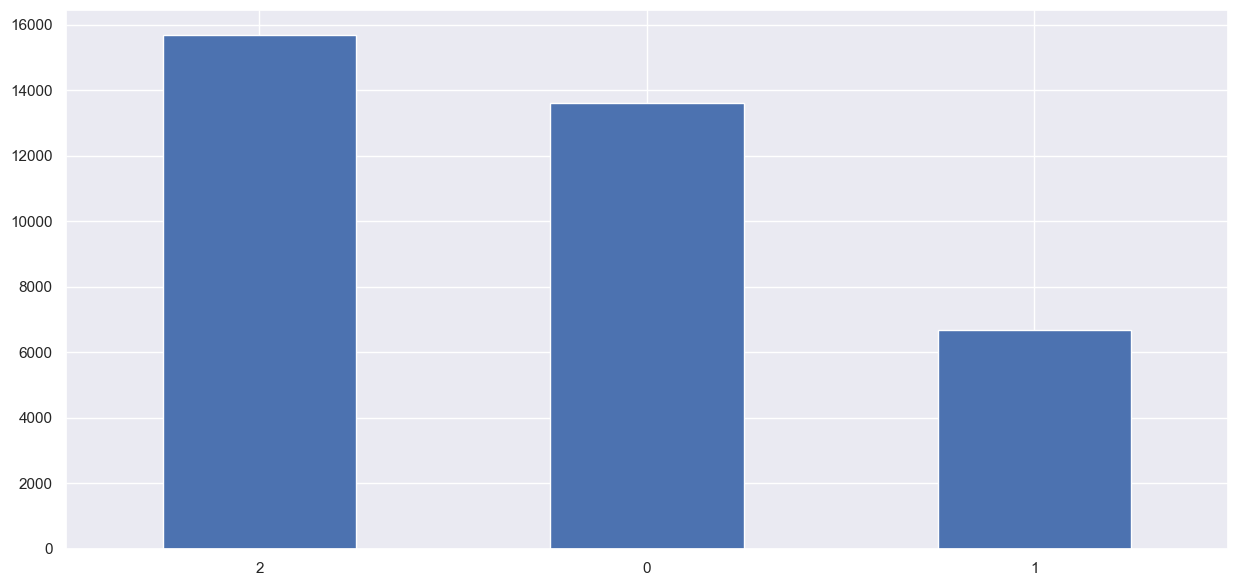

In [160]:
print(y_train.value_counts())
y_train.value_counts().plot(kind='bar',rot=0)

## 3. Vectorizing text ( *"Frequency based"* Word-embeddings)
- In this section, I will demonstrate 3 different word vectorization methods by processing sample data, then process the actual training, test data.
### 1) Vectorizing text with "Bag of Word" method for training.

In [167]:
from sklearn.feature_extraction.text import CountVectorizer
test = X_train[0:10] # sample data to visualize different vectorization
print(test.iloc[0])
countvectorizer = CountVectorizer(ngram_range=(1,1))
testX = countvectorizer.fit_transform(test).toarray()
countVectorOut = pd.DataFrame(data=testX, columns=countvectorizer.get_feature_names_out())
countVectorOut.head()

please help numerous complaints re forcing people amend dates booked holidays covid 19 crisis inflated prices reschedule lost money de


,19,2020,alone,amend,assistance,available,back,based,beware,big,...,urgent,used,vegas,visits,warn,water,weeks,will,woolworths,working
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Processing actual data with "BOW"

In [164]:
bowX_train = countvectorizer.fit_transform(X_train)
bowX_test = countvectorizer.transform(X_test)
print("BOWX_train shape : ",bowX_train.shape)
print("BOWX_test shape : ",bowX_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)
# y_train, y_valid

BOWX_train shape :  (35964, 42315)
BOWX_test shape :  (8991, 42315)
y_train shape :  (35964,)
y_test shape :  (8991,)


### 2) Vectorization with "N-gram" (bi-gram; n = 2)

In [192]:
ngramvectorizer = CountVectorizer(ngram_range=(2,2)) #max_features limit the #of bi-gram words
testX = ngramvectorizer.fit_transform(test).toarray()
ngramVectorOut = pd.DataFrame(data=testX, columns=ngramvectorizer.get_feature_names_out())
ngramVectorOut.head()

,19 crisis,19 development,19 symptoms,alone thinking,amend dates,available phone,back home,based gojo,beware counterfeiters,big deal,...,used distribution,vegas home,visits jackson,warn prepared,water food,weeks starting,will available,will enable,woolworths texted,working law
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Processing actual data with "bi-gram"

In [193]:
ngramX_train = ngramvectorizer.fit_transform(X_train)
ngramX_test = ngramvectorizer.transform(X_test)
print("ngramX_train shape : ",ngramX_train.shape)
print("ngramX_test shape : ",ngramX_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

ngramX_train shape :  (35964, 374175)
ngramX_test shape :  (8991, 374175)
y_train shape :  (35964,)
y_test shape :  (8991,)


### 3) Vectorization with "TF-IDF"

In [201]:
from sklearn.feature_extraction.text import TfidfVectorizer
#TF-IDF method
tfidfvectorizer = TfidfVectorizer()
testX = tfidfvectorizer.fit_transform(test).toarray()
tfidfVectorOut = pd.DataFrame(data=testX, columns=tfidfvectorizer.get_feature_names_out())
tfidfVectorOut.head()

,19,2020,alone,amend,assistance,available,back,based,beware,big,...,urgent,used,vegas,visits,warn,water,weeks,will,woolworths,working
0,0.154487,0.0,0.00000,0.233636,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.179121,0.0,0.000000,...,0.000000,0.179121,0.0,0.0,0.0,0.000000,0.0,0.152269,0.000000,0.0
2,0.000000,0.0,0.00000,0.000000,0.0,0.280756,0.0,0.000000,0.0,0.000000,...,0.330266,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.330266,0.0
3,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.247873,...,0.000000,0.000000,0.0,0.0,0.0,0.247873,0.0,0.000000,0.000000,0.0
4,0.147309,0.0,0.22278,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0


### Processing actual data with "TF-IDF"

In [202]:
tfidfX_train = tfidfvectorizer.fit_transform(X_train)
tfidfX_test = tfidfvectorizer.transform(X_test)
print("tfidfX_train shape : ",tfidfX_train.shape)
print("tfidfX_test shape : ",tfidfX_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

tfidfX_train shape :  (35964, 42315)
tfidfX_test shape :  (8991, 42315)
y_train shape :  (35964,)
y_test shape :  (8991,)


## 4. Comparing Models
### Now, we have numeritized data to be used in training with 3 different methods above. Let's compare different models with prepared data.
The models to be used:  
- Logistic Regression
- Naive Bayes
- Random Forest
- XGboost
- SVM

Different data on our hand:
- training data: bowX_train, ngramX_train, tfidfX_train / y_train
- test data: bowX_test, ngramX_test, tfidfX_test / y_test

### 1) Naive Bayes Classifier (Multinomial Naive Bayes)
- Naive Bayes Classifier is mostly used in text classification (due to better result in multiclass problems)
- Multinomial NB classifier is used for discrete counts.

In [203]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# multiNB = MultinomialNB()
name = ['BOW', 'Ngram', 'TF-IDF']
training_data = [bowX_train, ngramX_train, tfidfX_train]
test_data = [bowX_test, ngramX_test, tfidfX_test]

for i, X in enumerate(training_data):
    multiNB = MultinomialNB() #define a model
    print("="*40)
    print(f"Trained on {name[i]} data...")
    multiNB.fit(X,y_train) #train
    NB_prediction = multiNB.predict(test_data[i]) #predict
    NB_accuracy = metrics.accuracy_score(y_test, NB_prediction)
    print("Training accuracy : ", multiNB.score(X,y_train))
    print("Test accuracy : ", NB_accuracy)
    

Trained on BOW data...
Training accuracy :  0.8089756423089757
Test accuracy :  0.6829051273495718
Trained on Ngram data...
Training accuracy :  0.9796463129796463
Test accuracy :  0.5958180402624847
Trained on TF-IDF data...
Training accuracy :  0.7365142920698476
Test accuracy :  0.6502057613168725


### 2) Random Forest Classifier

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# multiNB = MultinomialNB()
name = ['BOW', 'Ngram', 'TF-IDF']
training_data = [bowX_train, ngramX_train, tfidfX_train]
test_data = [bowX_test, ngramX_test, tfidfX_test]

for i, X in enumerate(training_data):
    rf_clf = RandomForestClassifier() #define a model
    print("="*40)
    print(f"Trained on {name[i]} data...")
    rf_clf.fit(X,y_train) #train
    rf_prediction = rf_clf.predict(test_data[i]) #predict
    rf_accuracy = metrics.accuracy_score(y_test, rf_prediction)
    print("Training accuracy : ", rf_clf.score(X,y_train))
    print("Test accuracy : ", rf_accuracy)
    

Trained on BOW data...
Training accuracy :  0.9999165832499166
Test accuracy :  0.7541986430875319
Trained on Ngram data...
Training accuracy :  0.999582916249583
Test accuracy :  0.5491046602157713
Trained on TF-IDF data...
Training accuracy :  0.9999165832499166
Test accuracy :  0.7276165053942831


### 3) XGboost Classifier

In [206]:
import xgboost as xgb
from sklearn import metrics

# multiNB = MultinomialNB()
name = ['BOW', 'Ngram', 'TF-IDF']
training_data = [bowX_train, ngramX_train, tfidfX_train]
test_data = [bowX_test, ngramX_test, tfidfX_test]

for i, X in enumerate(training_data):
    xgb_clf = xgb.XGBClassifier() #define a model
    print("="*40)
    print(f"Trained on {name[i]} data...")
    xgb_clf.fit(X,y_train) #train
    xgb_prediction = xgb_clf.predict(test_data[i]) #predict
    xgb_accuracy = metrics.accuracy_score(y_test, xgb_prediction)
    print("Training accuracy : ", xgb_clf.score(X,y_train))
    print("Test accuracy : ", xgb_accuracy)
    

Trained on BOW data...
Training accuracy :  0.8106161717272828
Test accuracy :  0.7679902124346569
Trained on Ngram data...
Training accuracy :  0.5738794349905461
Test accuracy :  0.5362028695362029
Trained on TF-IDF data...
Training accuracy :  0.8122010899788678
Test accuracy :  0.7489711934156379


### 4) SVM Classifier

In [207]:
from sklearn.svm import SVC
from sklearn import metrics

# multiNB = MultinomialNB()
name = ['BOW', 'Ngram', 'TF-IDF']
training_data = [bowX_train, ngramX_train, tfidfX_train]
test_data = [bowX_test, ngramX_test, tfidfX_test]

for i, X in enumerate(training_data):
    svm_clf = SVC() #define a model
    print("="*40)
    print(f"Trained on {name[i]} data...")
    svm_clf.fit(X,y_train) #train
    svm_prediction = svm_clf.predict(test_data[i]) #predict
    svm_accuracy = metrics.accuracy_score(y_test, svm_prediction)
    print("Training accuracy : ", svm_clf.score(X,y_train))
    print("Test accuracy : ", svm_accuracy)
    

Trained on BOW data...
Training accuracy :  0.9458903347792237
Test accuracy :  0.7747747747747747
Trained on Ngram data...
Training accuracy :  0.9610165721276832
Test accuracy :  0.48882215548882213
Trained on TF-IDF data...
Training accuracy :  0.9786453119786453
Test accuracy :  0.7784451117784451


## 4. Defining a Baseline Model (Logistic Regression)
This model will be compared later with some advanced model including Neural Network.

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,tweet.Sentiment,test_size=0.2,shuffle=True,random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#Notice the shape of the data set. X row will be the nubmer of sentences(tweets) 
#and that of the columns are features

(35964, 48112) (8991, 48112) (35964,) (8991,)


In [213]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(bowX_train, y_train)
score = classifier.score(bowX_test, y_test)

print("Accuracy", score)

Accuracy 0.8048048048048048
